# MADE: Masked Autoencoder for Distribution Estimation on MNIST (Discretized Softmax)

This notebook implements the MADE architecture from the paper:
**"MADE: Masked Autoencoder for Distribution Estimation"** by Germain et al. (2015)

MADE is an autoregressive generative model that uses masked weight matrices to ensure the autoregressive property, allowing efficient density estimation and sampling.

This version uses **256-way softmax** to model pixel values as discrete categories (0-255), treating image generation as a classification problem for each pixel.

## 1. Import Required Libraries

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## 2. Load and Preprocess MNIST Dataset

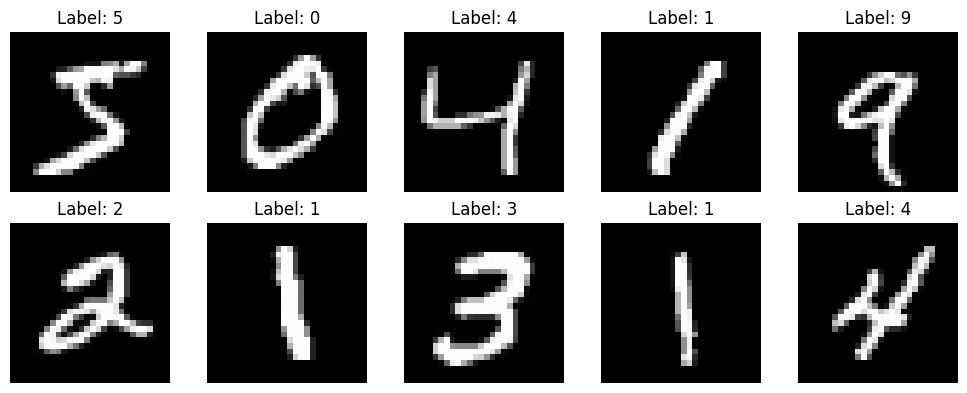

Training samples: 60000
Test samples: 10000
Input dimension: 784 (flattened)
Pixel value range: [0, 1] (continuous)


In [7]:
# Transform to normalize MNIST to [0, 1] range (continuous values)
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to [0, 1] range
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Visualize some samples
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.tight_layout()
plt.show()

print(f'Training samples: {len(train_dataset)}')
print(f'Test samples: {len(test_dataset)}')
print(f'Input dimension: {28 * 28} (flattened)')
print(f'Pixel value range: [0, 1] (continuous)')

## 3. Implement Masked Linear Layer

The core of MADE is the `MaskedLinear` layer, which applies element-wise masks to weight matrices to ensure the autoregressive property.

In [8]:
class MaskedLinear(nn.Linear):
    """
    Linear layer with a configurable mask on the weights.
    The mask ensures that connections respect the autoregressive property.
    """
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)
        self.register_buffer('mask', torch.ones(out_features, in_features))

    def set_mask(self, mask):
        """Set the mask for this layer."""
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.float32)))

    def forward(self, x):
        """Forward pass with masked weights."""
        return F.linear(x, self.weight * self.mask, self.bias)

## 4. Implement the MADE Model

The MADE model creates masks that enforce the autoregressive property:
- Each output dimension depends only on previous input dimensions
- Hidden units are assigned "degrees" that determine connectivity

In [9]:
class MADE(nn.Module):
    """
    Masked Autoencoder for Distribution Estimation with Discretized Softmax.

    Args:
        input_dim: Dimension of input (784 for MNIST)
        hidden_dims: List of hidden layer dimensions
        n_bins: Number of discrete bins (default 256 for pixel values 0-255)
        natural_ordering: If True, use natural ordering (1,2,3,...), else random
    """
    def __init__(self, input_dim, hidden_dims, n_bins=256, natural_ordering=True):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.n_bins = n_bins
        self.natural_ordering = natural_ordering

        # Build network layers
        self.layers = nn.ModuleList()
        dims = [input_dim] + hidden_dims + [input_dim * n_bins]  # Output: logits for each bin per pixel

        for i in range(len(dims) - 1):
            self.layers.append(MaskedLinear(dims[i], dims[i+1]))

        # Create masks
        self.create_masks()

    def create_masks(self):
        """
        Create masks for all layers to enforce autoregressive property.

        The key idea:
        - Assign each input dimension a number from 1 to D
        - Assign each hidden unit a number from 1 to D-1
        - A hidden unit with degree k can only connect to inputs with degree <= k
        - Output i can only connect to hidden units with degree < i
        """
        L = len(self.hidden_dims)

        # Assign degrees to each layer
        # m[l] contains the degrees for layer l
        self.m = {}

        # Input layer: degrees are 1, 2, ..., D (natural ordering) or permutation
        if self.natural_ordering:
            self.m[0] = np.arange(1, self.input_dim + 1)
        else:
            self.m[0] = np.random.permutation(np.arange(1, self.input_dim + 1))

        # Hidden layers: degrees are randomly sampled from 1 to D-1
        for l in range(1, L + 1):
            # Sample degrees between min(m[l-1]) and D-1
            self.m[l] = np.random.randint(
                self.m[l-1].min(),
                self.input_dim,
                size=self.hidden_dims[l-1]
            )

        # Output layer: repeat input degrees for all bins
        self.m[L + 1] = np.repeat(self.m[0], self.n_bins)

        # Create masks based on degrees
        masks = []
        for l in range(len(self.layers)):
            if l < len(self.layers) - 1:
                # Hidden layer mask: m[l+1][i] >= m[l][j]
                mask = (self.m[l + 1][:, None] >= self.m[l][None, :]).astype(np.float32)
            else:
                # Output layer mask: m[l+1][i] > m[l][j] (strict inequality)
                mask = (self.m[l + 1][:, None] > self.m[l][None, :]).astype(np.float32)

            masks.append(mask)
            self.layers[l].set_mask(mask)

    def forward(self, x):
        """
        Forward pass through the network.
        Returns logits for categorical distributions over each dimension.

        Args:
            x: Input tensor of shape (batch_size, input_dim) with values in [0, 1]

        Returns:
            logits: Tensor of shape (batch_size, input_dim, n_bins)
        """
        # Flatten input if needed
        if len(x.shape) > 2:
            x = x.view(x.size(0), -1)

        # Pass through layers with ReLU activations (except last layer)
        for i, layer in enumerate(self.layers[:-1]):
            x = F.relu(layer(x))

        # Last layer without activation (outputs logits)
        x = self.layers[-1](x)

        # Reshape to (batch_size, input_dim, n_bins)
        logits = x.view(-1, self.input_dim, self.n_bins)

        return logits

    def sample(self, n_samples):
        """
        Generate samples using ancestral sampling.
        Sample each dimension sequentially conditioned on previous dimensions.
        """
        samples = torch.zeros(n_samples, self.input_dim).to(device)

        with torch.no_grad():
            for i in range(self.input_dim):
                # Forward pass to get logits
                logits = self.forward(samples)

                # Get probabilities for dimension i
                probs = F.softmax(logits[:, i, :], dim=1)

                # Sample from categorical distribution
                bins = torch.multinomial(probs, 1).float().squeeze(1)

                # Convert bin index back to [0, 1] range
                samples[:, i] = bins / (self.n_bins - 1)

        return samples

## 5. Initialize the Model

In [10]:
# Model hyperparameters
input_dim = 28 * 28  # 784 for MNIST
hidden_dims = [500]  # Two hidden layers with 500 units each
n_bins = 256  # Number of discrete intensity levels

# Create model
model = MADE(input_dim, hidden_dims, n_bins=n_bins, natural_ordering=True).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params:,}')
print(f'Number of bins: {n_bins}')
print(f'\nModel architecture:')
#print(f'Input -> {hidden_dims[0]} -> {hidden_dims[1]} -> {input_dim * n_bins} (reshaped to {input_dim} x {n_bins})')

Total parameters: 100,945,204
Number of bins: 256

Model architecture:


## 6. Define Loss Function and Optimizer

For discretized MNIST, we use categorical cross-entropy loss, treating each pixel as a 256-class classification problem.

In [11]:
def discretized_loss(logits, target, n_bins=256):
    """
    Compute categorical cross-entropy loss for discretized pixel values.

    Args:
        logits: Model output (batch_size, input_dim, n_bins)
        target: Target data (batch_size, input_dim) with values in [0, 1]
        n_bins: Number of discrete bins (default 256)

    Returns:
        Average negative log-likelihood per sample
    """
    # Convert continuous [0, 1] to discrete bins [0, n_bins-1]
    target_bins = (target * (n_bins - 1)).long()
    target_bins = torch.clamp(target_bins, 0, n_bins - 1)  # Ensure valid range

    # Reshape logits: [batch_size * input_dim, n_bins]
    batch_size, input_dim, _ = logits.shape
    logits_flat = logits.reshape(-1, n_bins)
    target_flat = target_bins.reshape(-1)

    # Cross entropy loss
    loss = F.cross_entropy(logits_flat, target_flat, reduction='none')

    # Reshape and sum over dimensions, average over batch
    loss = loss.view(batch_size, input_dim)
    return loss.sum(dim=1).mean()

# Optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(f'Optimizer: Adam with learning rate {learning_rate}')
print(f'Loss: Categorical cross-entropy (256-way softmax per pixel)')
print(f'Each pixel is treated as a {n_bins}-class classification problem')

Optimizer: Adam with learning rate 0.0001
Loss: Categorical cross-entropy (256-way softmax per pixel)
Each pixel is treated as a 256-class classification problem


## 7. Training Loop

In [12]:
def train_epoch(model, train_loader, optimizer):
    """Train for one epoch."""
    model.train()
    train_loss = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(data.size(0), -1).to(device)

        optimizer.zero_grad()
        logits = model(data)
        loss = discretized_loss(logits, data, n_bins=n_bins)
        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

        optimizer.step()

        train_loss += loss.item()

    return train_loss / len(train_loader)

def evaluate(model, test_loader):
    """Evaluate on test set."""
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.view(data.size(0), -1).to(device)
            logits = model(data)
            loss = discretized_loss(logits, data, n_bins=n_bins)
            test_loss += loss.item()

    return test_loss / len(test_loader)

# Training
num_epochs = 20
train_losses = []
test_losses = []

print('Starting training...\n')

for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch(model, train_loader, optimizer)
    test_loss = evaluate(model, test_loader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f'Epoch {epoch:2d}/{num_epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}')

print('\nTraining complete!')

Starting training...

Epoch  1/20 | Train Loss: 2759.6970 | Test Loss: 1976.9848
Epoch  2/20 | Train Loss: 1809.2860 | Test Loss: 1653.0600
Epoch  3/20 | Train Loss: 1527.3421 | Test Loss: 1399.1708
Epoch  4/20 | Train Loss: 1294.6663 | Test Loss: 1197.1730
Epoch  5/20 | Train Loss: 1125.7864 | Test Loss: 1063.3127
Epoch  6/20 | Train Loss: 1020.9423 | Test Loss: 983.9787
Epoch  7/20 | Train Loss: 956.5995 | Test Loss: 933.0092
Epoch  8/20 | Train Loss: 912.2849 | Test Loss: 896.6526
Epoch  9/20 | Train Loss: 879.2955 | Test Loss: 869.4209
Epoch 10/20 | Train Loss: 853.9314 | Test Loss: 848.8020
Epoch 11/20 | Train Loss: 834.0541 | Test Loss: 832.7780
Epoch 12/20 | Train Loss: 818.0061 | Test Loss: 820.1062
Epoch 13/20 | Train Loss: 804.7234 | Test Loss: 809.6895
Epoch 14/20 | Train Loss: 793.4463 | Test Loss: 800.8762
Epoch 15/20 | Train Loss: 783.7636 | Test Loss: 793.6264
Epoch 16/20 | Train Loss: 775.3535 | Test Loss: 787.3950
Epoch 17/20 | Train Loss: 768.0275 | Test Loss: 782.143

## 8. Visualize Training Progress

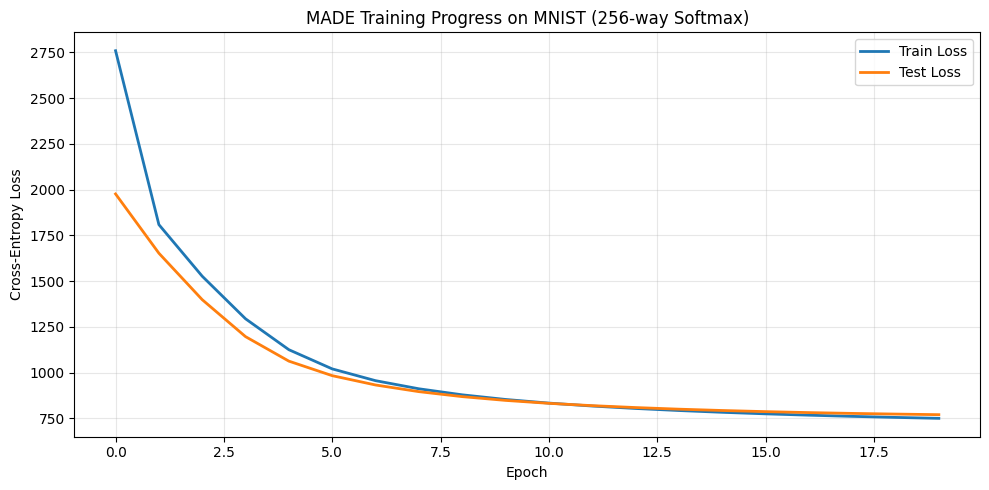

Final Train Loss: 750.7564
Final Test Loss: 770.7958


In [13]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(test_losses, label='Test Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.title('MADE Training Progress on MNIST (256-way Softmax)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f'Final Train Loss: {train_losses[-1]:.4f}')
print(f'Final Test Loss: {test_losses[-1]:.4f}')

## 9. Generate Samples Using Ancestral Sampling

MADE can generate new samples by sequentially sampling each pixel conditioned on previously sampled pixels.

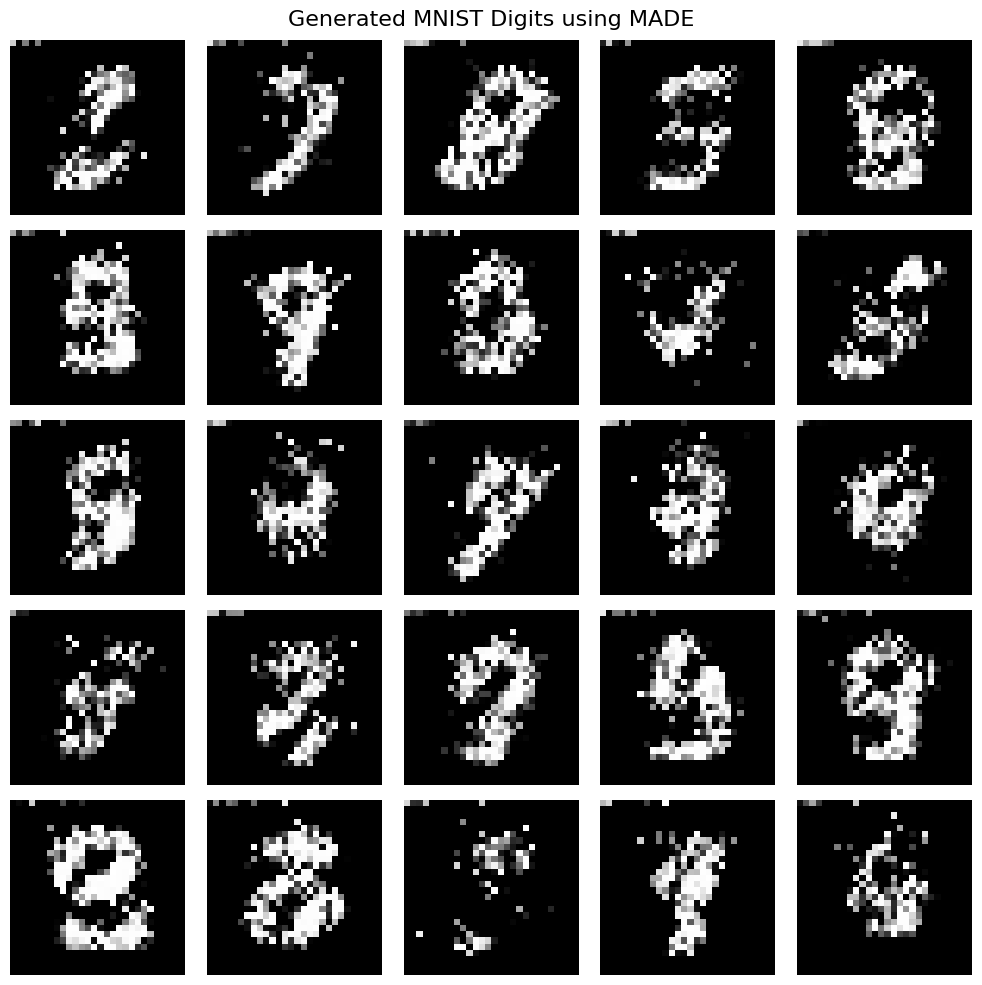

In [14]:
# Generate samples
model.eval()
n_samples = 25
samples = model.sample(n_samples)

# Reshape and visualize
samples = samples.cpu().numpy().reshape(-1, 28, 28)

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i], cmap='gray')
    ax.axis('off')
plt.suptitle('Generated MNIST Digits using MADE', fontsize=16)
plt.tight_layout()
plt.show()

## 10. Evaluate Model - Log-Likelihood per Dimension

Calculate the average bits per dimension on the test set (a common metric for generative models).

In [15]:
# Calculate bits per dimension
model.eval()
total_nll = 0
total_samples = 0

with torch.no_grad():
    for data, _ in test_loader:
        data = data.view(data.size(0), -1).to(device)
        logits = model(data)

        # Convert to bins
        target_bins = (data * (n_bins - 1)).long()
        target_bins = torch.clamp(target_bins, 0, n_bins - 1)

        # Compute cross-entropy
        batch_size, input_dim, _ = logits.shape
        logits_flat = logits.reshape(-1, n_bins)
        target_flat = target_bins.reshape(-1)

        nll = F.cross_entropy(logits_flat, target_flat, reduction='sum')
        total_nll += nll.item()
        total_samples += data.size(0)

avg_nll_per_sample = total_nll / total_samples
avg_nll_per_dim = avg_nll_per_sample / input_dim
bits_per_dim = avg_nll_per_dim / np.log(2)  # Convert from nats to bits

print(f'Test Set Evaluation:')
print(f'  Average NLL per sample: {avg_nll_per_sample:.4f} nats')
print(f'  Average NLL per dimension: {avg_nll_per_dim:.4f} nats')
print(f'  Bits per dimension: {bits_per_dim:.4f} bits')
print(f'\nNote: Lower values indicate better density estimation.')
print(f'Theoretical minimum for {n_bins} bins: {np.log2(n_bins):.2f} bits/dim (uniform distribution)')

Test Set Evaluation:
  Average NLL per sample: 771.0270 nats
  Average NLL per dimension: 0.9835 nats
  Bits per dimension: 1.4188 bits

Note: Lower values indicate better density estimation.
Theoretical minimum for 256 bins: 8.00 bits/dim (uniform distribution)


## 11. Visualize Learned Distributions

We can visualize what the model has learned by examining the predicted probability distributions for each pixel.

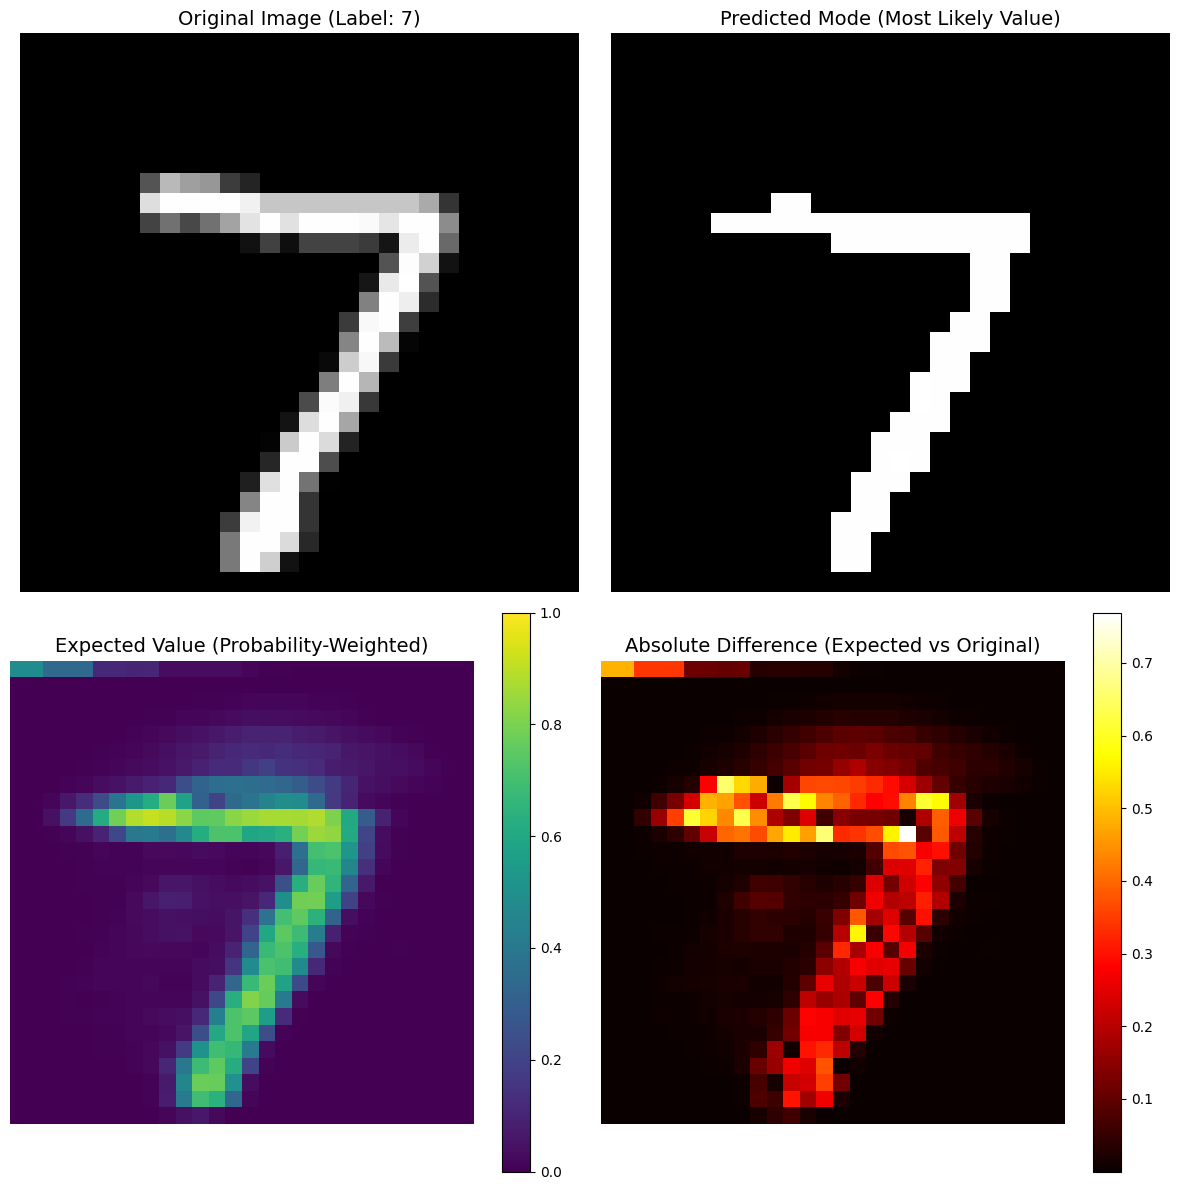

Mean absolute error (expected): 0.0678
Mean absolute error (mode): 0.0475
Average entropy per pixel: 0.9330 nats


In [16]:
# Take a test image and visualize predicted distributions
model.eval()
test_img, test_label = test_dataset[0]
test_img_flat = test_img.view(1, -1).to(device)

with torch.no_grad():
    logits = model(test_img_flat)
    probs = F.softmax(logits, dim=2)  # (1, input_dim, n_bins)

# Get the mode (most likely value) for each pixel
predicted_bins = torch.argmax(probs, dim=2).float()
predicted_img = (predicted_bins / (n_bins - 1)).cpu().numpy().reshape(28, 28)
predicted_img = np.clip(predicted_img, 0, 1)

# Get expected value for each pixel
bin_values = torch.arange(n_bins, device=device).float() / (n_bins - 1)
expected_img = (probs[0] * bin_values).sum(dim=1).cpu().numpy().reshape(28, 28)
expected_img = np.clip(expected_img, 0, 1)

test_img_show = test_img.squeeze().cpu().numpy()

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Original image
axes[0, 0].imshow(test_img_show, cmap='gray')
axes[0, 0].set_title(f'Original Image (Label: {test_label})', fontsize=14)
axes[0, 0].axis('off')

# Predicted mode
axes[0, 1].imshow(predicted_img, cmap='gray')
axes[0, 1].set_title('Predicted Mode (Most Likely Value)', fontsize=14)
axes[0, 1].axis('off')

# Expected value
im = axes[1, 0].imshow(expected_img, cmap='viridis', vmin=0, vmax=1)
axes[1, 0].set_title('Expected Value (Probability-Weighted)', fontsize=14)
axes[1, 0].axis('off')
plt.colorbar(im, ax=axes[1, 0])

# Difference (using expected value)
diff = np.abs(test_img_show - expected_img)
im2 = axes[1, 1].imshow(diff, cmap='hot')
axes[1, 1].set_title('Absolute Difference (Expected vs Original)', fontsize=14)
axes[1, 1].axis('off')
plt.colorbar(im2, ax=axes[1, 1])

plt.tight_layout()
plt.show()

print(f'Mean absolute error (expected): {diff.mean():.4f}')
print(f'Mean absolute error (mode): {np.abs(test_img_show - predicted_img).mean():.4f}')
print(f'Average entropy per pixel: {-(probs[0] * torch.log(probs[0] + 1e-10)).sum(dim=1).mean().item():.4f} nats')

## 12. Visualize Reconstruction Quality

Compare original test images with the model's predicted probabilities to see how well it captures the data.

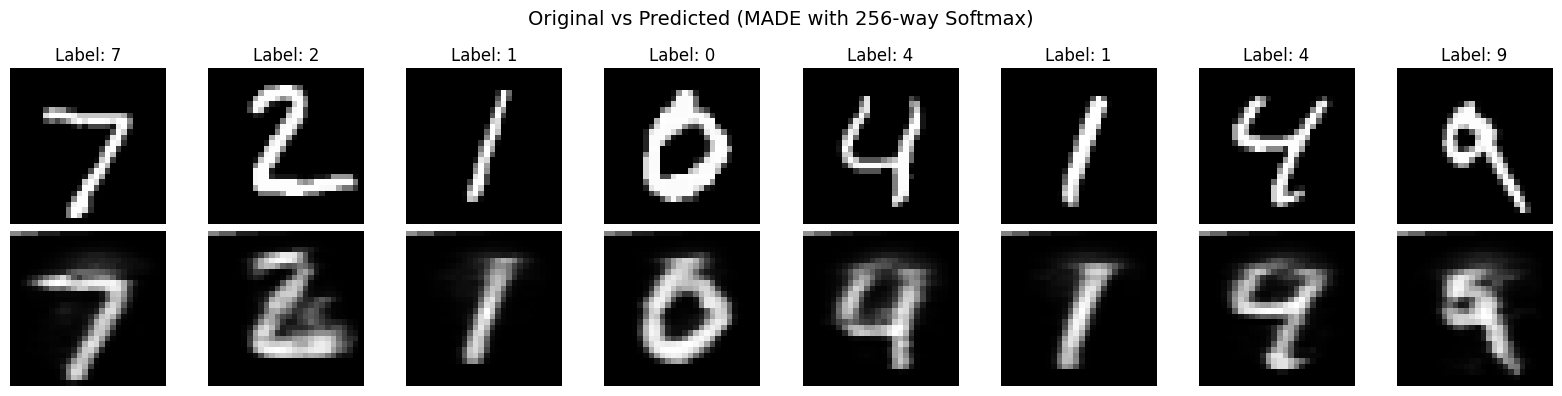

In [17]:
# Take some test images and compare with predictions
model.eval()
n_compare = 8

# Get a batch of test images
test_images = []
test_labels = []
for i in range(n_compare):
    img, label = test_dataset[i]
    test_images.append(img)
    test_labels.append(label)

test_images = torch.stack(test_images).to(device)
test_images_flat = test_images.view(n_compare, -1)

with torch.no_grad():
    logits = model(test_images_flat)
    probs = F.softmax(logits, dim=2)

    # Get expected values
    bin_values = torch.arange(n_bins, device=device).float() / (n_bins - 1)
    expected_values = (probs * bin_values).sum(dim=2)

# Reshape predictions
expected_images = expected_values.cpu().numpy().reshape(n_compare, 28, 28)
expected_images = np.clip(expected_images, 0, 1)

# Original images
orig_images = test_images.cpu().numpy().squeeze(1)  # Remove channel dimension

# Plot comparisons
fig, axes = plt.subplots(2, n_compare, figsize=(16, 4))

for i in range(n_compare):
    # Original
    axes[0, i].imshow(orig_images[i], cmap='gray')
    axes[0, i].set_title(f'Label: {test_labels[i]}')
    axes[0, i].axis('off')

    # Predicted expected value
    axes[1, i].imshow(expected_images[i], cmap='gray')
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('Original', fontsize=12)
axes[1, 0].set_ylabel('Predicted\nExpected Value', fontsize=12)

plt.suptitle('Original vs Predicted (MADE with 256-way Softmax)', fontsize=14)
plt.tight_layout()
plt.show()

## 13. Conditional Image Completion

Demonstrate the autoregressive property by conditioning on partial images and completing them.

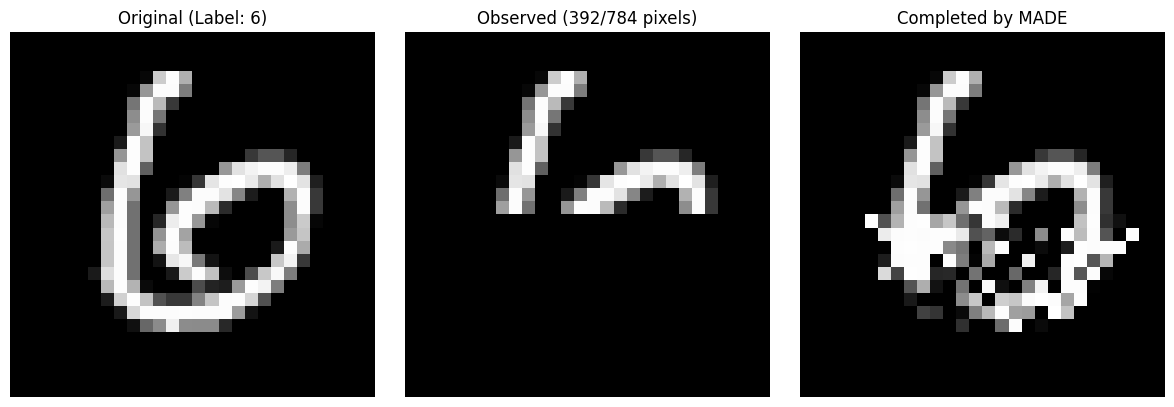

Completed image by sampling 392 pixels conditioned on 392 observed pixels.
Each pixel sampled from a 256-way categorical distribution.


In [18]:
# Conditional completion: give the model the left half, generate the right half
model.eval()
test_img, test_label = test_dataset[11]
test_img_flat = test_img.view(1, -1).to(device)

# Create a partial image (first N pixels known, rest to be generated)
# Each row has 28 pixels, and we have 28 rows
# Total ordering: pixels in natural order
# For simplicity, let's condition on the first 50% of dimensions

partial_img = torch.zeros_like(test_img_flat)
n_observed = input_dim // 2  # 392 pixels

# Copy observed pixels from original image
partial_img[:, :n_observed] = test_img_flat[:, :n_observed]

# Sequentially sample the rest
with torch.no_grad():
    for i in range(n_observed, input_dim):
        logits = model(partial_img)

        # Get probabilities for pixel i
        probs = F.softmax(logits[:, i, :], dim=1)

        # Sample from categorical distribution
        bin_sample = torch.multinomial(probs, 1).float().squeeze(1)

        # Convert to [0, 1] range
        partial_img[:, i] = bin_sample / (n_bins - 1)

# Reshape for visualization
original = test_img.squeeze(0).cpu().numpy()  # Remove channel dimension
completed = partial_img.cpu().numpy().reshape(28, 28)
completed = np.clip(completed, 0, 1)

# Create a mask showing what was observed
mask_flat = np.zeros(28 * 28)
mask_flat[:n_observed] = 1.0

# Reshape to (28, 28)
mask = mask_flat.reshape(28, 28)
observed = original * mask

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(original, cmap='gray')
axes[0].set_title(f'Original (Label: {test_label})')
axes[0].axis('off')

axes[1].imshow(observed, cmap='gray')
axes[1].set_title(f'Observed ({n_observed}/{input_dim} pixels)')
axes[1].axis('off')

axes[2].imshow(completed, cmap='gray')
axes[2].set_title('Completed by MADE')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f'Completed image by sampling {input_dim - n_observed} pixels conditioned on {n_observed} observed pixels.')
print(f'Each pixel sampled from a 256-way categorical distribution.')

## 14. Calculate FID Score

Fréchet Inception Distance (FID) measures the quality of generated images by comparing their statistics to real images using an Inception network.

In [19]:
from scipy import linalg
from torchvision.models import inception_v3

def get_inception_model():
    """Load pretrained InceptionV3 model for FID calculation."""
    inception = inception_v3(pretrained=True, transform_input=False)
    inception.fc = nn.Identity()  # Remove final classification layer
    inception.eval()
    return inception.to(device)

def preprocess_for_inception(images):
    """
    Preprocess images for Inception network.

    Args:
        images: Tensor of shape (N, 1, 28, 28) in [0, 1] range (grayscale)

    Returns:
        Tensor of shape (N, 3, 299, 299) suitable for InceptionV3
    """
    # Convert grayscale to RGB by repeating channels
    if images.shape[1] == 1:
        images = images.repeat(1, 3, 1, 1)

    # Resize to 299x299 (Inception input size)
    images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)

    # Normalize to [-1, 1] range (Inception expects this)
    images = (images - 0.5) / 0.5

    return images

def get_inception_features(images, inception_model, batch_size=32):
    """
    Extract features from images using InceptionV3.

    Args:
        images: Tensor of shape (N, 1, H, W) or (N, 3, H, W)
        inception_model: Pretrained InceptionV3 model
        batch_size: Batch size for processing

    Returns:
        Features of shape (N, 2048)
    """
    inception_model.eval()
    features_list = []

    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            batch = images[i:i+batch_size]
            batch = preprocess_for_inception(batch).to(device)

            # Get features
            features = inception_model(batch)
            features_list.append(features.cpu())

    return torch.cat(features_list, dim=0).numpy()

def calculate_fid(real_features, fake_features):
    """
    Calculate Fréchet Inception Distance between real and generated images.

    Args:
        real_features: Features from real images (N, 2048)
        fake_features: Features from generated images (M, 2048)

    Returns:
        FID score (float)
    """
    # Calculate mean and covariance
    mu_real = np.mean(real_features, axis=0)
    sigma_real = np.cov(real_features, rowvar=False)

    mu_fake = np.mean(fake_features, axis=0)
    sigma_fake = np.cov(fake_features, rowvar=False)

    # Calculate FID
    diff = mu_real - mu_fake

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma_real @ sigma_fake, disp=False)

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff @ diff + np.trace(sigma_real + sigma_fake - 2 * covmean)

    return float(fid)

print("FID calculation functions defined successfully!")
print("Note: FID calculation requires downloading pretrained InceptionV3 (≈100MB)")

FID calculation functions defined successfully!
Note: FID calculation requires downloading pretrained InceptionV3 (≈100MB)


In [20]:
# Load Inception model
print("Loading InceptionV3 model...")
inception_model = get_inception_model()
print("InceptionV3 loaded successfully!")

# Generate samples for FID calculation
print("\nGenerating samples for FID calculation...")
n_fid_samples = 5000  # Use 5000 samples for reliable FID estimate
model.eval()

# Generate in batches to avoid memory issues
batch_size_gen = 500
all_generated_samples = []

for i in range(0, n_fid_samples, batch_size_gen):
    batch_size_current = min(batch_size_gen, n_fid_samples - i)
    samples_batch = model.sample(batch_size_current)
    # Reshape to (N, 1, 28, 28)
    samples_batch = samples_batch.view(batch_size_current, 1, 28, 28)
    all_generated_samples.append(samples_batch)
    print(f"Generated {i + batch_size_current}/{n_fid_samples} samples")

generated_samples = torch.cat(all_generated_samples, dim=0)
print(f"Generated samples shape: {generated_samples.shape}")

# Get real images from test set
print("\nExtracting real images from test set...")
real_images_list = []
for i in range(n_fid_samples):
    img, _ = test_dataset[i % len(test_dataset)]
    real_images_list.append(img)

real_images = torch.stack(real_images_list)
print(f"Real images shape: {real_images.shape}")

# Extract features
print("\nExtracting features from real images...")
real_features = get_inception_features(real_images, inception_model, batch_size=32)
print(f"Real features shape: {real_features.shape}")

print("\nExtracting features from generated images...")
fake_features = get_inception_features(generated_samples, inception_model, batch_size=32)
print(f"Generated features shape: {fake_features.shape}")

# Calculate FID
print("\nCalculating FID score...")
fid_score = calculate_fid(real_features, fake_features)

print(f"\n{'='*50}")
print(f"FID Score: {fid_score:.2f}")
print(f"{'='*50}")
print("\nNote: Lower FID scores indicate better quality generated images.")
print("Typical FID ranges:")
print("  - FID < 50: Good quality")
print("  - FID 50-100: Moderate quality")
print("  - FID > 100: Poor quality")

Loading InceptionV3 model...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 139MB/s] 


InceptionV3 loaded successfully!

Generating samples for FID calculation...
Generated 500/5000 samples
Generated 1000/5000 samples
Generated 1500/5000 samples
Generated 2000/5000 samples
Generated 2500/5000 samples
Generated 3000/5000 samples
Generated 3500/5000 samples
Generated 4000/5000 samples
Generated 4500/5000 samples
Generated 5000/5000 samples
Generated samples shape: torch.Size([5000, 1, 28, 28])

Extracting real images from test set...
Real images shape: torch.Size([5000, 1, 28, 28])

Extracting features from real images...
Real features shape: (5000, 2048)

Extracting features from generated images...
Generated features shape: (5000, 2048)

Calculating FID score...


/tmp/ipython-input-3952767325.py:81: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(sigma_real @ sigma_fake, disp=False)



FID Score: 172.02

Note: Lower FID scores indicate better quality generated images.
Typical FID ranges:
  - FID < 50: Good quality
  - FID 50-100: Moderate quality
  - FID > 100: Poor quality


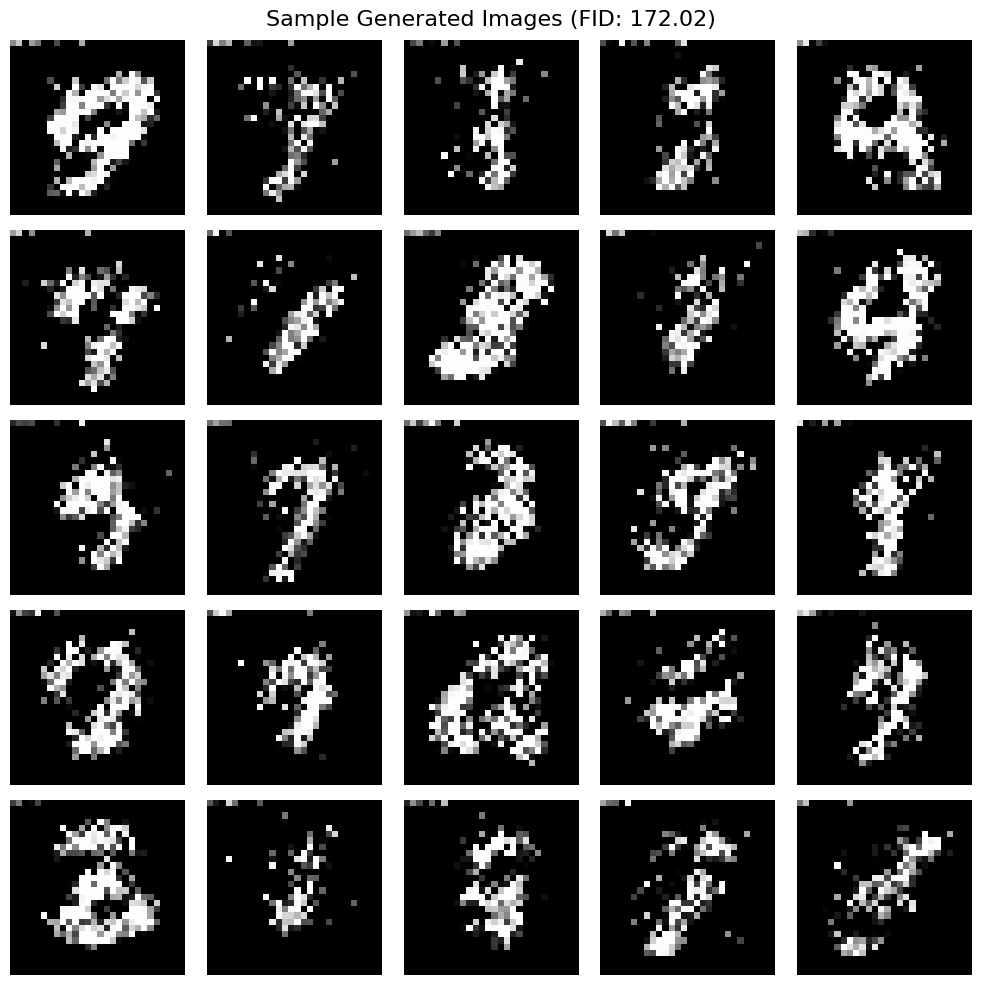

In [21]:
# Visualize some generated samples used for FID
n_vis = 25
vis_samples = generated_samples[:n_vis].cpu().numpy()

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(vis_samples[i].squeeze(), cmap='gray')
    ax.axis('off')
plt.suptitle(f'Sample Generated Images (FID: {fid_score:.2f})', fontsize=16)
plt.tight_layout()
plt.show()

## Summary

This notebook implemented **MADE (Masked Autoencoder for Distribution Estimation)** with **256-way softmax** on MNIST, a powerful autoregressive generative model. Key highlights:

1. **Masked Connections**: Used masked weight matrices to enforce autoregressive dependencies
2. **Efficient Training**: Unlike traditional autoregressive models, MADE computes all conditional probabilities in a single forward pass
3. **Discretized Softmax**: Models pixel values as 256 discrete categories (0-255), treating each pixel as a classification problem
4. **Exact Likelihoods**: Provides exact log-likelihood computation without approximations
5. **Ancestral Sampling**: Generated new samples by sequentially sampling pixels from learned categorical distributions

The model learns to capture the joint distribution $p(x_1, x_2, ..., x_{784})$ by factorizing it as:
$$p(x) = \prod_{i=1}^{784} \text{Categorical}(x_i | \text{logits}_i(x_{<i}))$$

where each pixel $x_i$ is modeled as one of 256 possible intensity values.

**Advantages of 256-way softmax:**
- Exact likelihood computation (no Gaussian approximation)
- Can model arbitrary distributions (multimodal, discrete)
- No assumptions about continuous distributions

**Trade-offs:**
- More output parameters (256 per pixel vs 2 for Gaussian)
- Higher computational cost
- Better suited for truly discrete or complex distributions

This architecture forms the basis for more advanced models like PixelCNN and modern autoregressive flows!